In [1]:
import os

# Paper Node
Reads each paper with its index, year, and other papers that this paper referenced.

In [2]:
class paper_node: 
    def __init__(self):
        self.index = None
        self.year = None
        self.refs = []

    def __str__(self):
        return f'paper {self.index}  year {self.year}  refs{self.refs}'
    def __repr__(self):
        return f'paper {self.index}  year {self.year}  refs{self.refs}'

In [3]:
os.getcwd()

'/Users/rezatabrizi/dev/Repos/CAPP'

## Parser of the citation network data

In [4]:
citation = {}

with open ("../../../Downloads/v1_citation_net.txt", "r") as net_file:
    lines = net_file.readlines()
    i = 1
    while (i < len(lines)):
        v = paper_node()  
        while(len(lines[i]) > 1 and lines[i][1] != '*'):
            line = lines[i].strip()
            if (line[1] == 't'):
                v.year=line.split('t')[1]
            elif line[1] == '%':
                v.refs.append(line.split('%')[1])
            elif line[1:6] == "index":
                v.index = line.split('x')[1] 
            i += 1
        
        if(len(lines[i])<=1):
            citation [v.index] = v
        i += 1

In [14]:
citation

{'0': paper 0  year 2006  refs[],
 '1': paper 1  year 2003  refs[],
 '2': paper 2  year 2007  refs[],
 '3': paper 3  year 2005  refs[],
 '4': paper 4  year 2006  refs[],
 '5': paper 5  year 2006  refs['436405'],
 '6': paper 6  year 2006  refs[],
 '7': paper 7  year 2007  refs[],
 '8': paper 8  year 1987  refs[],
 '9': paper 9  year 2006  refs[],
 '10': paper 10  year 2005  refs[],
 '11': paper 11  year 2006  refs[],
 '12': paper 12  year 2007  refs[],
 '13': paper 13  year 1996  refs[],
 '14': paper 14  year 2005  refs[],
 '15': paper 15  year 2005  refs[],
 '16': paper 16  year 2007  refs[],
 '17': paper 17  year 2006  refs['357875', '214023', '317448', '319987', '334185', '95255', '294124', '96319', '610127'],
 '18': paper 18  year 2005  refs[],
 '19': paper 19  year 2003  refs[],
 '20': paper 20  year 2005  refs[],
 '21': paper 21  year 2006  refs[],
 '22': paper 22  year 1997  refs[],
 '23': paper 23  year 2005  refs[],
 '24': paper 24  year 2006  refs['251778', '436906', '623227',

4


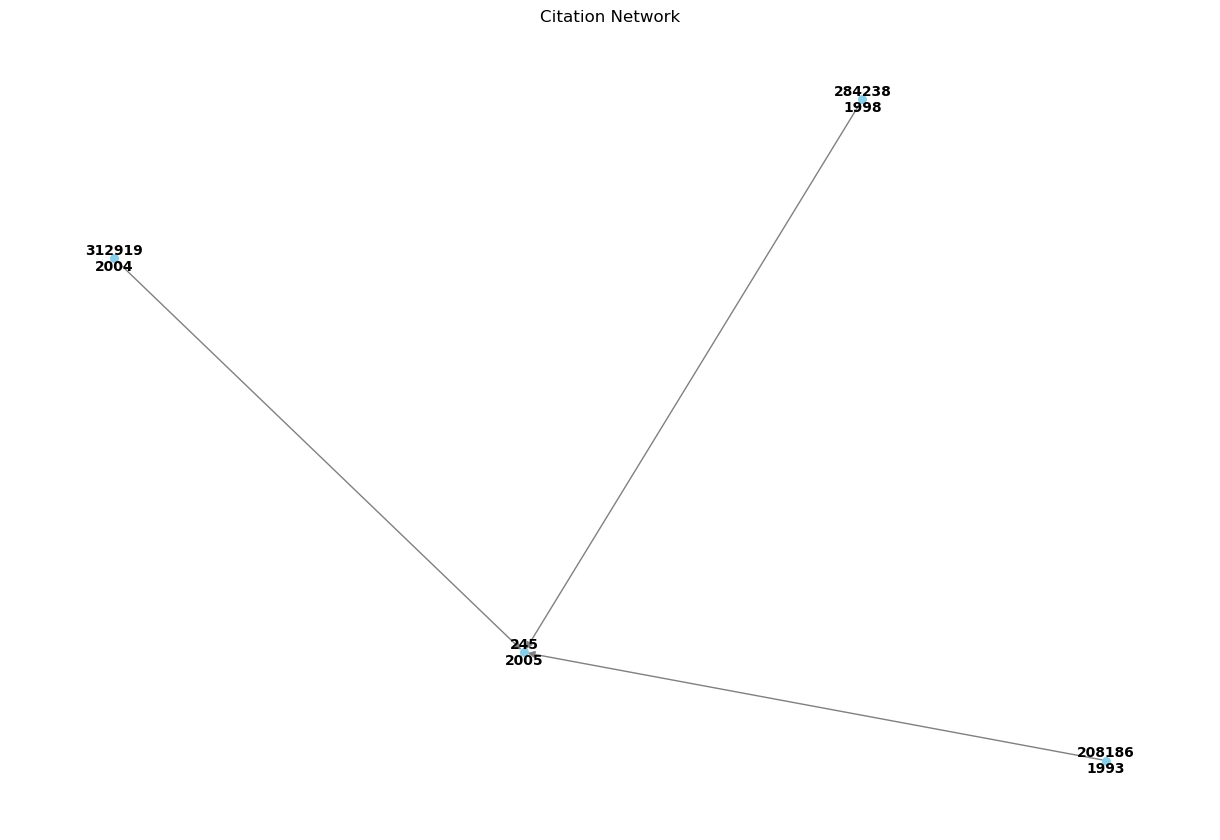

In [60]:
import networkx as nx
import matplotlib.pyplot as plt

def build_subgraph(citation, start_node):
    G = nx.DiGraph()
    visited = set()

    def add_node_and_refs(node_id):
        if node_id not in visited:
            visited.add(node_id)
            node = citation[node_id]
            G.add_node(node_id, year=node.year)
            for ref in node.refs:
                G.add_edge(ref, node_id)
                add_node_and_refs(ref)

    add_node_and_refs(start_node)
    return G

def draw_graph(G):
    pos = nx.spring_layout(G)
    years = nx.get_node_attributes(G, 'year')
    print(len(years))
    labels = {node: f"{node}\n{years[node]}" for node in G.nodes()}

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=30, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')
    plt.title("Citation Network")
    plt.show()

# Specify the start node
start_node = "245"
G = build_subgraph(citation, start_node)
draw_graph(G)

## Graph Node

In [71]:
class graph_node:
    def __init__(self):
        self.children = []
        self.year = None
        self.index = None
    def __repr__(self):
        return f'paper {self.index}  year {self.year}  children{self.children}'

# Graph
This graph has each paper as being the parent with the children being the papers that cited the parent

In [72]:
graph = {}
for child_index, node in citation.items():
    for parent_index in node.refs:
        if parent_index not in graph:
            u = graph_node()
            u.year = citation[parent_index].year
            u.index = parent_index
            graph[parent_index] = u
        if child_index not in graph:
            v = graph_node()
            v.year = node.year
            v.index = child_index
            graph[child_index] = v
        graph[parent_index].children.append(child_index)

# Citation to Normalized Graph
Given a citation Graph from ahovem this method turns everyting to sequential, 0 indexed graph where the first node starts from 0 and every node moves up from 0 all the way to node n. 

In [77]:
def generate_normalized_graph(graph):
    current_mapping = 0
    zero_indexed_graph = {}
    node_mapping_dict = {}
    for old_node_index, node in graph.items(): 
        if old_node_index not in node_mapping_dict: 
            node_mapping_dict[old_node_index] = current_mapping
            current_mapping += 1
        u_new_index = node_mapping_dict[old_node_index]
        zero_indexed_graph[u_new_index] = []
        for old_child_index in node.children:
            if old_child_index not in node_mapping_dict:
                node_mapping_dict[old_child_index] = current_mapping
                current_mapping += 1
            v_new_index = node_mapping_dict[old_child_index]
            zero_indexed_graph[u_new_index].append(v_new_index)
    return zero_indexed_graph

In [78]:
graph = generate_normalized_graph(graph)

In [12]:
# graph['625569']
# def dfs (u, graph, visited):
#     visited[u] = 1
#     for v in graph[u].children: 
#         if v in visited and visited[v] == 1:
#             print(f"{v}")
#             return True 
#         elif v not in visited and dfs(v, graph, visited):
#             print ('^')
#             print(f"{u} -> {v}")
#             return True
#     visited[u] = 2 
#     return False 
# print(dfs('625569', graph, {}))

# DFS (Cascade Generator) 
This function produces the cascades by finding the longest distnace from when the seed node is visited to when each other node is visited. The algorithm is some modified version of the dfs algorithm

In [104]:
def dfs (parent,  u, hops, graph, distance, visited):
    visited.add(u)
    if u not in distance or distance[u] < hops:
        distance[u] = hops
    for v in graph[u]:
            if v not in visited and ((v in distance and distance[v] < hops+1) or v not in distance): 
                dfs(parent, v, hops+1, graph, distance, visited)
    visited.remove(u)

In [109]:
sample_graph = {
    1: [2, 3, 5],
    2: [5],
    3: [4, 6],
    4: [],
    5: [6, 7],
    6: [],
    7: [8],
    8: []
}
distance = {}
visited = set()
dfs(1, 1, 0, sample_graph, distance, visited)
x = sorted(distance)
x

[1, 2, 3, 4, 5, 6, 7, 8]

# Generates Cascades using DFS 
Note that this can run for a very long time, so we paused it after generating about 7.5k casacdes. 

In [103]:
def generate_cascade(graph):
    cascade_idx = 0
    for node in graph:
        visited = set()
        distance  = {}
        dfs (node, node, 0, graph, distance, visited)
        activations = [(n, t) for n, t in distance.items()]
        activations = sorted(activations, key= lambda x: x[1])
        if len(activations) <= 3: 
            continue
        with open('data/raw/citation_network/cascades.txt', "a") as f:
            f.write(f"{cascade_idx} ")
            for node, time in activations:
                f.write(f"{node}:{time} ")
            f.write("\n")
        cascade_idx += 1
generate_cascade(graph)

NameError: name 'dfs' is not defined

In [63]:
information = {}
with open ("data/raw/citation_network/cascades.txt", "r") as f:
    csc = f.readlines()
    for idx, cascade in enumerate(csc):
        cascade = cascade.strip()
        cascade = cascade.split(' ')[1:]
        cascade = [(int(activation.split(':')[0]), int(activation.split(':')[1])) for activation in cascade]
        information[idx] = cascade

In [114]:
modified_graph = {}
for node in information:
    modified_graph[node] = graph[node]
    for other_node, _ in information[node]:   
        modified_graph[other_node] = graph[other_node]

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline

(array([  0.,   0.,   0.,   0., 129.,  73.,  68.,  59.,  53.,  39.,  47.,
         27.,  36.,  21.,  24.,  21.,  16.,  18.,  17.,  19.,  16.,  12.,
         13.,  13.,   7.,  17.,  14.,  10.,   6.,   9.,  11.,   7.,   7.,
         10.,  12.,  10.,   5.,  13.,   4.,  10.,   9.,  10.,   8.,  12.,
          3.,   2.,   0.,   7.,   9.,   3.,   4.,   5.,   3.,   6.,   9.,
          3.,   4.,   1.,   7.,   1.,   1.,   4.,   2.,   4.,   3.,   3.,
          0.,   5.,   4.,   4.,   1.,   1.,   5.,   6.,   2.,   2.,   3.,
          2.,   2.,   4.,   1.,   2.,   1.,   1.,   2.,   5.,   0.,   0.,
          1.,   0.,   4.,   4.,   2.,   1.,   2.,   1.,   6.,   0.,   2.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
        52., 53., 54., 55., 56., 57., 58

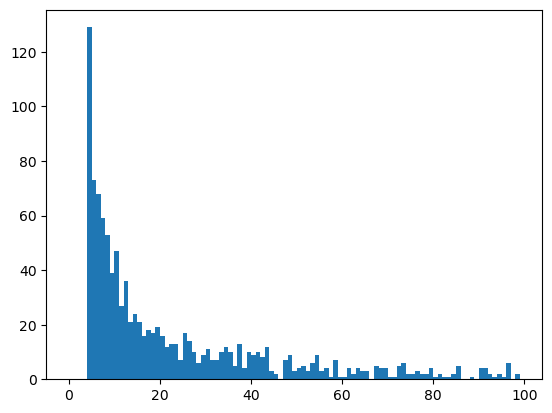

In [119]:
cascade_size = lambda information: [len(information[cascade]) for cascade in information]
plt.hist(cascade_size(information), bins=range(100))


In [121]:
with open ("/Users/rezatabrizi/dev/Repos/CAPP/data/raw/citation_network/adj.txt", "w") as f:
    citation_network_edges = []
    for u in modified_graph: 
        for v in modified_graph[u]:
            citation_network_edges.append([u, v])
            f.write(f"{u} {v}\n")

In [122]:
import networkx as nx 
citation_network_edges
citation_nx_g = nx.DiGraph()
citation_nx_g.add_edges_from(citation_network_edges)

In [123]:
import numpy as np
cascade_end_time = lambda information: [information[cascade][-1][1] for cascade in information]
average_diffusion_time = np.array(cascade_end_time(information)).mean()
print(f"Average Diffusion time: {average_diffusion_time} hops")

Average Diffusion time: 10.304610318331504 hops


AtlasView({1: {}, 2: {}, 3: {}, 4: {}, 5: {}, 6: {}})

In [133]:
def generate_static_centrality_features (G, n):
    degree_centrality_facebook = nx.degree_centrality(G)
    print("degree centrality done")
    eigenvector_centrality_facebook = nx.eigenvector_centrality(G)
    print("EV centrality done")
    #betweeness_centrality_facebook = nx.betweenness_centrality(G)
    #print("Betweeness centrality done")
    
    with open ('/Users/rezatabrizi/dev/Repos/CAPP/data/raw/citation_network/node_features.txt', 'w') as file: 
        for node_idx in G:
            #file.write(f"{node_idx} {degree_centrality_facebook[node_idx]} {eigenvector_centrality_facebook[node_idx]} {betweeness_centrality_facebook[node_idx]}\n")
            file.write(f"{node_idx} {degree_centrality_facebook[node_idx]} {eigenvector_centrality_facebook[node_idx]}\n")

In [134]:
generate_static_centrality_features(citation_nx_g, len(graph))

degree centrality done
EV centrality done


84155


In [113]:
len(graph)

217335